In [10]:
import sys
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:./mlruns")  # always use the root mlruns
mlflow.set_experiment("credit_scoring")


sys.path.append("..")

from src.data_prep import build_datasets, build_preprocessor

train_df, test_df = build_datasets()

X = train_df.drop(columns=["TARGET"])
y = train_df["TARGET"]

preprocessor = build_preprocessor(train_df)


2025/12/13 01:54:23 INFO mlflow.tracking.fluent: Experiment with name 'credit_scoring' does not exist. Creating a new experiment.


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # important à cause du déséquilibre
    n_jobs=-1
)

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg),
])


In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    clf,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

print("AUC moyenne (5-fold):", scores.mean())
print("Écart-type:", scores.std())


AUC moyenne (5-fold): 0.6364517241381489
Écart-type: 0.0029263192410341667


In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight="balanced_subsample",  # utile pour le déséquilibre
    random_state=42
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf),
])


In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_val_score(
    rf_clf,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

print("RF - AUC moyenne (5-fold):", rf_scores.mean())
print("RF - Écart-type:", rf_scores.std())


RF - AUC moyenne (5-fold): 0.7331777554943234
RF - Écart-type: 0.002944569949436284


RF AUC ≈ 0.733
AUC moyenne (5-fold): 0.6364517241381489
un gain de 0.10

In [11]:
models = {
    "logreg_baseline": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "rf_baseline": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=42,
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ])

    with mlflow.start_run(run_name=name):
        # Cross-val AUC
        scores = cross_val_score(
            clf,
            X,
            y,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )
        auc_mean = scores.mean()
        auc_std  = scores.std()

        # Log params principaux (exemple)
        mlflow.log_param("model_type", name)
        if name == "rf_baseline":
            mlflow.log_param("n_estimators", model.n_estimators)
            mlflow.log_param("max_depth", model.max_depth)

        # Log métriques
        mlflow.log_metric("auc_mean", auc_mean)
        mlflow.log_metric("auc_std", auc_std)

        # Fit sur tout le train pour logguer le modèle complet
        clf.fit(X, y)
        mlflow.sklearn.log_model(clf, artifact_path="model")

        print(name, "AUC:", auc_mean)


2025/12/13 02:04:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 02:04:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


logreg_baseline AUC: 0.6364517241381489


2025/12/13 02:11:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 02:11:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


rf_baseline AUC: 0.7331777554943234


In [12]:
import mlflow
mlflow.get_tracking_uri()


'file:./mlruns'

In [13]:
import sys
sys.path.append("..")  # to import from src/

from src.data_prep import build_preprocessor
from src.metrics import compute_classic_metrics, business_cost, cost_curve

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# 1) Split data
X = train_df.drop(columns=["TARGET"])
y = train_df["TARGET"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

# 2) Build pipeline
preprocessor = build_preprocessor(train_df)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42,
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf),
])

# 3) Train
rf_clf.fit(X_train, y_train)

# 4) Probabilities on validation set
y_valid_proba = rf_clf.predict_proba(X_valid)[:, 1]


In [14]:
# classic metrics at threshold 0.5
metrics_05 = compute_classic_metrics(y_valid, y_valid_proba, threshold=0.5)
metrics_05

{'auc': np.float64(0.7366507877117965),
 'precision': 0.55,
 'recall': 0.002215508559919436,
 'f1': 0.0044132397191574725}

In [15]:
thresholds, costs = cost_curve(
    y_valid,
    y_valid_proba,
    cost_fn=10.0,
    cost_fp=1.0,
    normalize=True,
)

best_idx = costs.argmin()
best_threshold = thresholds[best_idx]
best_cost = costs[best_idx]

best_threshold, best_cost


(np.float64(0.1), np.float64(0.5527697835877925))

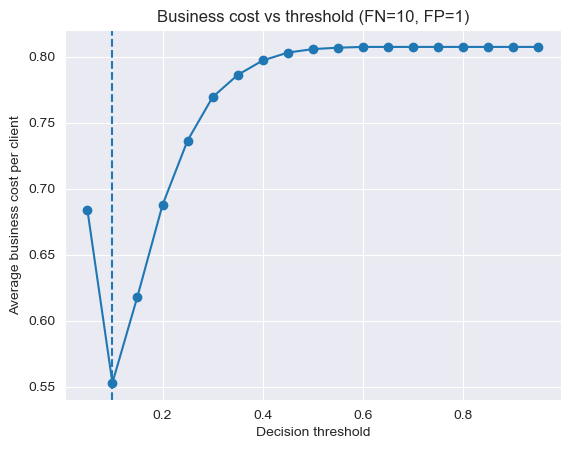

In [20]:
import matplotlib.pyplot as plt

plt.plot(thresholds, costs, marker="o")
plt.axvline(best_threshold, linestyle="--")
plt.xlabel("Decision threshold")
plt.ylabel("Average business cost per client")
plt.title("Business cost vs threshold (FN=10, FP=1)")
plt.savefig("../reports/figures/courbe_cout_vs_seuil.png", bbox_inches="tight")
plt.show()



In [17]:
from src.metrics import compute_classic_metrics, business_cost

metrics_05 = compute_classic_metrics(y_valid, y_valid_proba, threshold=0.5)
cost_05, conf_05 = business_cost(y_valid, y_valid_proba, threshold=0.5)

metrics_01 = compute_classic_metrics(y_valid, y_valid_proba, threshold=0.1)
cost_01, conf_01 = business_cost(y_valid, y_valid_proba, threshold=0.1)

metrics_05, cost_05, conf_05, metrics_01, cost_01, conf_01


({'auc': np.float64(0.7366507877117965),
  'precision': 0.55,
  'recall': 0.002215508559919436,
  'f1': 0.0044132397191574725},
 np.float64(0.8056354974554086),
 {'tn': np.int64(56529),
  'fp': np.int64(9),
  'fn': np.int64(4954),
  'tp': np.int64(11)},
 {'auc': np.float64(0.7366507877117965),
  'precision': 0.17518507551080842,
  'recall': 0.5957703927492447,
  'f1': 0.27075514874141876},
 np.float64(0.5527697835877925),
 {'tn': np.int64(42611),
  'fp': np.int64(13927),
  'fn': np.int64(2007),
  'tp': np.int64(2958)})

In [21]:
import sys
sys.path.append("..")

from src.data_prep import build_preprocessor
from src.metrics import cost_curve, business_cost, compute_classic_metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

import mlflow
import mlflow.sklearn


In [22]:
X = train_df.drop(columns=["TARGET"])
y = train_df["TARGET"]

preprocessor = build_preprocessor(train_df)


In [23]:
rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    class_weight="balanced_subsample",  # handles class imbalance a bit
    random_state=42,
)

final_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf_final),
])


In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(
    final_pipeline,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,   # instead of -1
)

print("Final RF AUC mean:", auc_scores.mean())
print("Final RF AUC std:", auc_scores.std())


Final RF AUC mean: 0.7331777554943234
Final RF AUC std: 0.002944569949436284


In [26]:
final_pipeline.fit(X, y)
FINAL_THRESHOLD = 0.10  # from your cost curve


In [27]:
mlflow.set_tracking_uri("file:./mlruns")       # same as before
mlflow.set_experiment("credit_scoring")        # or "Default" if you prefer

with mlflow.start_run(run_name="rf_final_model"):
    # Log key params (you can add more if you want)
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", rf_final.n_estimators)
    mlflow.log_param("max_depth", rf_final.max_depth)
    mlflow.log_param("max_features", rf_final.max_features)
    mlflow.log_param("class_weight", "balanced_subsample")
    mlflow.log_param("business_threshold", FINAL_THRESHOLD)

    # Log CV AUC
    mlflow.log_metric("cv_auc_mean", float(auc_scores.mean()))
    mlflow.log_metric("cv_auc_std", float(auc_scores.std()))

    # OPTIONAL: evaluate cost on full train with the final threshold
    y_train_proba = final_pipeline.predict_proba(X)[:, 1]
    cost_train, _ = business_cost(y, y_train_proba, threshold=FINAL_THRESHOLD)
    mlflow.log_metric("train_business_cost", float(cost_train))

    # 1) Log model as MLflow artifact (for tracking / registry)
    mlflow.sklearn.log_model(
        sk_model=final_pipeline,
        artifact_path="model",
    )

    # 2) Save the same model to ../model for Docker / serving
    mlflow.sklearn.save_model(
        sk_model=final_pipeline,
        path="../model"
    )


2025/12/13 09:47:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/13 09:47:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
